# The basic paintbox classes

The spectral energy distribution (SED) of galaxies can be decomposite into different parts, such as the light from the stars, the emission lines from the gas, and the attenuation of the light as a whole owing to dust absorption. Similarly, `paintbox` uses different ingredients to build a model for the SED that com be combined to produce a SED model. Here we describe the main classes used for this purpose.

### Non-parametric models 

Often the components in the SED can be modeled as a combination of templates, and this method have been extensively explored by some tools such as [`ppxf`](https://pypi.org/project/ppxf/) and [`Starlight`](http://www.starlight.ufsc.br/). One instance is the modeling of emission lines, which we use below to produce some templates with the built-in tools from `ppxf`. 

Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6731_d1' '[SII]6731_d2'
 '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


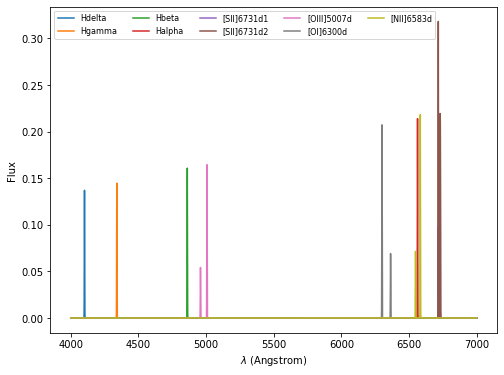

In [16]:
import os
import numpy as np
import astropy.units as u
from astropy.modeling import models
import matplotlib.pyplot as plt
import paintbox as pb
from paintbox import utils
from ppxf import ppxf_util, miles_util

# Generating an wavelenght array spaced logarithmically with
# fixed velocity scale
wrange = [4000, 7000]
velscale = 30 # Velocity shift between pixels
FWHM = 2.8 # Resolution of the observation

# Simple tool to get velocity dispersion with fixed velscale within a given range
wave = utils.disp2vel(wrange, velscale) 
logwave = np.log(wave)

gas_templates, gas_names, line_wave = ppxf_util.emission_lines(
        logwave, [wave[0], wave[-1]], FWHM,
        tie_balmer=False, limit_doublets=True)
gas_names = [_.replace("_", "") for _ in gas_names] # Removing underlines from names
fig = plt.figure(figsize=(8, 6))
for i in range(len(gas_names)):
    plt.plot(wave, gas_templates[:,i], label=gas_names[i])
plt.legend(ncol=5, prop={"size": 8})
plt.xlabel("$\lambda$ (Angstrom)")
plt.ylabel("Flux")
plt.show()

In `paintbox`, a combination of such templates can be invoked with the `NonParametricModel` class, which can be used to produce an SED with any combination. 

Name of the parameters ['Hdelta', 'Hgamma', 'Hbeta', 'Halpha', '[SII]6731d1', '[SII]6731d2', '[OIII]5007d', '[OI]6300d', '[NII]6583d']
Random fluxes of emission lines: 
('Hdelta', 0.3990546446177675) ('Hgamma', 0.3720088069901858) ('Hbeta', 0.6910604161313084) ('Halpha', 0.8516915271249351) ('[SII]6731d1', 0.029682220572311957) ('[SII]6731d2', 0.9276260263988682) ('[OIII]5007d', 0.03600336387628489) ('[OI]6300d', 0.24220613814452097) ('[NII]6583d', 0.49044717730270126)


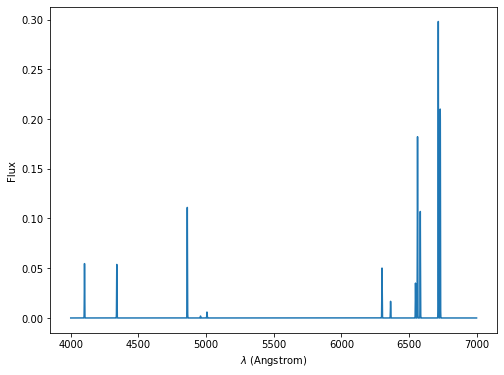

In [15]:
# Creating paintbox component
emission = pb.NonParametricModel(wave, gas_templates.T, gas_names)
print("Name of the parameters", emission.parnames)
# Generating some random flux for each emission line
theta = np.random.random(len(gas_names))
print("Random fluxes of emission lines: ")
print(*zip(emission.parnames, theta))
fig = plt.figure(figsize=(8, 6))
plt.plot(wave, emission(theta))
plt.xlabel("$\lambda$ (Angstrom)")
plt.ylabel("Flux")
plt.show()

### Parametric models

In several applications, we are interested in the determination of the parameters involved in the modeling of the SED, for instance, the age or the metallicity of a stellar population model that better describes some observations. The `NonParametricModel`class above can be used for that purpose, of course, but the problem of determining the correct weights becomes more difficult as we include more templates. One alternative is thus tointerpolate the models such that we can have a SED description for any particular combination of parameters within a convex hull defined by the limits of the model. In this case, we can use the `paintbox.ParametricModel` class. In the example below, we use a set of theoretical stellar models from [Coelho (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.440.1027C/abstract), which you can download [here](http://specmodels.iag.usp.br/) to demonstrate how to use this class.

In [3]:
import os

from astropy.io import fits
from astropy.table import Table, vstack

models_dir = "s_coelho14_sed"
# Getting parameters from file names
model_names = os.listdir(models_dir)
# Get dispersion from the header of a file
filename = os.path.join(models_dir, model_names[0])
crval1 = fits.getval(filename, "CRVAL1")
cdelt1 = fits.getval(filename, "CDELT1")
n = fits.getval(filename, "NAXIS1")
pix = np.arange(n) + 1
wave = np.power(10, crval1 + cdelt1 * pix) * u.micrometer
table = []
templates = np.zeros((len(model_names), n))
for i, filename in enumerate(model_names):
    T = float(filename.split("_")[0][1:])
    g = float(filename.split("_")[1][1:])
    Z = 0.1 * float(filename.split("_")[2][:3].replace(
        "m", "-").replace("p", "+"))
    alpha = 0.1 * float(filename.split("_")[2][3:].replace(
        "m", "-").replace("p", "+"))
    a = np.array([T, g, Z, alpha])
    t = Table(a, names=["T", "g", "Z", "alpha"])
    table.append(t)
    templates[i] = fits.getdata(os.path.join(models_dir, filename))
table = vstack(table) # Join all tables in one

Parameters:  ['T', 'g', 'Z', 'alpha']
Limits for the parameter:  {'T': (3000.0, 26000.0), 'g': (-0.5, 5.5), 'Z': (-1.3, 0.2), 'alpha': (0.0, 0.4)}


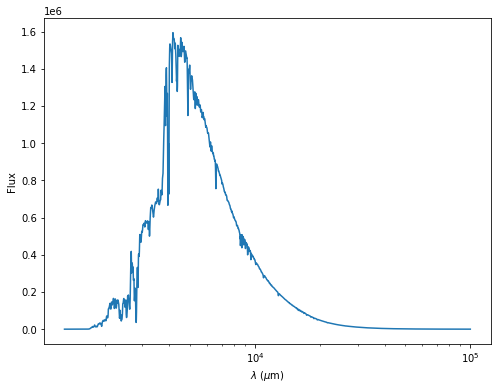

In [12]:
# Use paintbox to interpolate models.
star = pb.ParametricModel(wave, table, templates)
print("Parameters: ", star.parnames)
print("Limits for the parameter: ", star.limits)
theta = np.array([6500, 3., -0.1, 0.1])
fig = plt.figure(figsize=(8, 6))
plt.semilogx(wave, star(theta))
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Flux")
plt.show()